Summary:
Run scCODA approach (Bayesian dirichlet method) for cell type specific compositional analysis across 4 age groups representing the human lifespan. Data includes the CITE-seq dataset of 7 centenarians and 2 younger controls, as well as samples from 2 publicly available single cell datasets of aging and longevity. 

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import arviz as az


In [2]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

2022-12-06 16:24:41.710541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 16:24:41.710593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 16:24:41.847390: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 16:24:52.687430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 16:24:52.687926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [3]:
#load cell counts of samples per cell type
cell_counts = pd.read_csv("/restricted/projectnb/uh2-sebas/analysis/scCentenarians/Composition_Multinomial/scCoda_Composition_Analysis/ct_cell_counts.csv")
cell_counts

,sample_ID,nCD4TC,mCD4TC,cCD4TC,cCD8TC,gdTC,nBC,mBC,pBC,NK,M14,M16,mDC,pDC
0,BU10,263.5,361.5,23.5,530.5,0.5,29.5,16.5,0.5,515.5,179.5,14.5,13.5,16.5
1,BU6,164.5,341.5,4.5,341.5,0.5,63.5,38.5,0.5,168.5,289.5,22.5,23.5,21.5
2,CT1,1335.5,606.5,216.5,20.5,7.5,186.5,147.5,3.5,176.5,458.5,99.5,36.5,13.5
3,CT2,947.5,399.5,153.5,39.5,57.5,565.5,65.5,5.5,1793.5,533.5,345.5,29.5,18.5
4,CT3,712.5,168.5,69.5,26.5,16.5,533.5,98.5,6.5,627.5,252.5,43.5,8.5,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,SCN4,261.5,223.5,331.5,423.5,0.5,11.5,79.5,0.5,176.5,288.5,11.5,27.5,7.5
62,SCN5,131.5,371.5,134.5,487.5,0.5,17.5,23.5,0.5,130.5,322.5,24.5,12.5,5.5
63,SCN6,463.5,409.5,22.5,258.5,0.5,18.5,16.5,0.5,495.5,296.5,52.5,21.5,10.5
64,SCN7,8.5,46.5,169.5,1046.5,0.5,52.5,19.5,0.5,202.5,558.5,53.5,23.5,7.5


In [4]:
#read in metadata information for each sample
sample_metadata = pd.read_csv("/restricted/projectnb/uh2-sebas/analysis/scCentenarians/Composition_Multinomial/scCoda_Composition_Analysis/sample_metadata.csv")
sample_metadata = sample_metadata.drop(sample_metadata.columns[[0]], axis=1)
sample_metadata

,sample_ID,age_group,sex,batch
0,BU10,Younger,Female,NECS.B1
1,BU6,Middle,Male,NECS.B1
2,CT1,Middle,Male,PNAS
3,CT2,Older,Female,PNAS
4,CT3,Older,Female,PNAS
...,...,...,...,...
61,SCN4,EL,Female,NECS.B1
62,SCN5,EL,Female,NECS.B2
63,SCN6,EL,Male,NECS.B1
64,SCN7,EL,Male,NECS.B2


In [5]:
#create anndata object
ct_anndat = dat.from_pandas(cell_counts, covariate_columns=["sample_ID"])
ct_anndat.obs = sample_metadata
ct_anndat

AnnData object with n_obs × n_vars = 66 × 13
    obs: 'sample_ID', 'age_group', 'sex', 'batch'

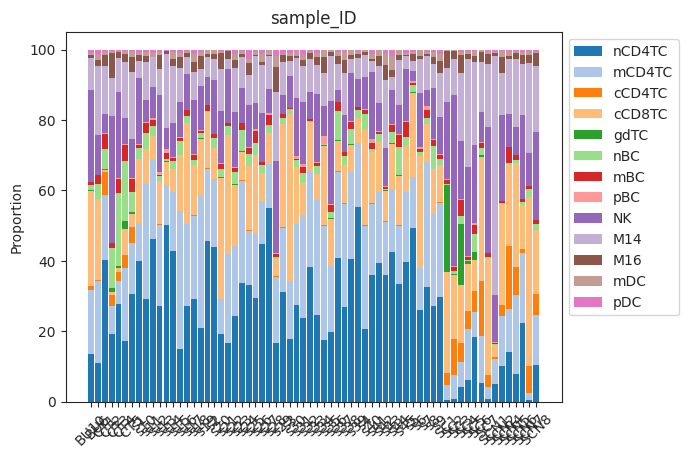

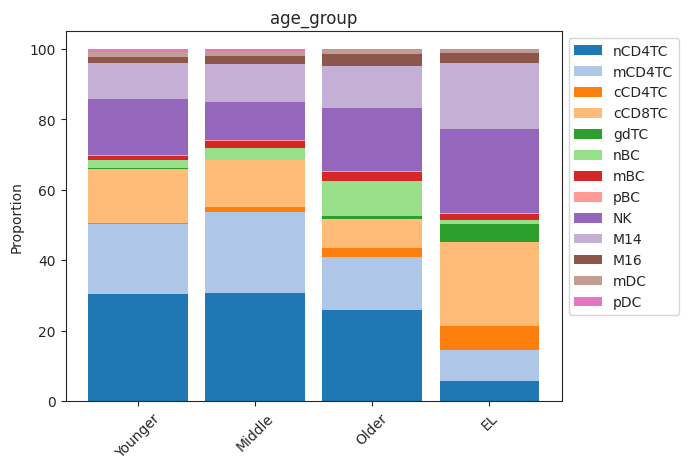

In [6]:
# Stacked barplot for each sample
viz.stacked_barplot(ct_anndat, feature_name="sample_ID")
plt.show()

# Stacked barplot for the levels of "age.quartiles"
viz.stacked_barplot(ct_anndat, feature_name="age_group")
plt.show()

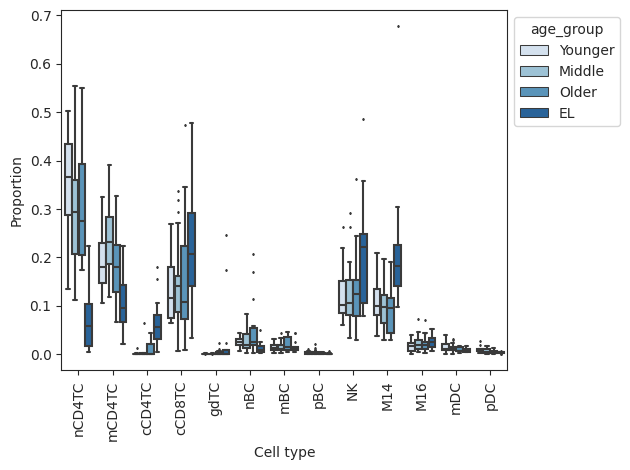

In [7]:
# Grouped boxplots. No facets, relative abundance, no dots.
viz.boxplots(
    ct_anndat,
    feature_name="age_group",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
)
plt.show()


Run scCODA with each cell type as the reference:

In [8]:
# Run scCODA with each cell type as the reference
cell_types = ct_anndat.var.index
results_cycle_middle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)
results_cycle_older = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)
results_cycle_EL = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(ct_anndat, formula="C(age_group, Treatment('Younger')) + C(sex, Treatment('Male'))", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff_EL = temp_results.credible_effects()[0:12]
    cred_eff_EL.index = cred_eff_EL.index.droplevel(level=0)
    
    cred_eff_middle = temp_results.credible_effects()[13:25]
    cred_eff_middle.index = cred_eff_middle.index.droplevel(level=0)
    
    cred_eff_older = temp_results.credible_effects()[26:38]
    cred_eff_older.index = cred_eff_older.index.droplevel(level=0)

    # add up credible effects
    results_cycle_middle["times_credible"] += cred_eff_middle.astype("int")
    results_cycle_older["times_credible"] += cred_eff_older.astype("int")
    results_cycle_EL["times_credible"] += cred_eff_EL.astype("int")

Reference: nCD4TC


2022-12-06 16:25:18.016152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 16:25:18.016224: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 16:25:18.016274: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (scc-ka4): /proc/driver/nvidia/version does not exist
2022-12-06 16:25:25.152655: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2b3114137a60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-06 16:25:25.152827: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2022-12-06 16:25:25.297341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268]

MCMC sampling finished. (603.757 sec)
Acceptance rate: 66.2%
Reference: mCD4TC


100%|██████████| 20000/20000 [07:45<00:00, 43.00it/s]


MCMC sampling finished. (588.157 sec)
Acceptance rate: 58.7%
Reference: cCD4TC


100%|██████████| 20000/20000 [07:46<00:00, 42.85it/s]


MCMC sampling finished. (592.203 sec)
Acceptance rate: 44.3%
Reference: cCD8TC


100%|██████████| 20000/20000 [07:55<00:00, 42.02it/s]


MCMC sampling finished. (600.607 sec)
Acceptance rate: 39.6%
Reference: gdTC


100%|██████████| 20000/20000 [07:49<00:00, 42.62it/s]


MCMC sampling finished. (595.831 sec)
Acceptance rate: 54.6%
Reference: nBC


100%|██████████| 20000/20000 [07:56<00:00, 41.94it/s]


MCMC sampling finished. (605.517 sec)
Acceptance rate: 54.4%
Reference: mBC


100%|██████████| 20000/20000 [08:06<00:00, 41.15it/s]


MCMC sampling finished. (615.203 sec)
Acceptance rate: 69.6%
Reference: pBC


100%|██████████| 20000/20000 [07:55<00:00, 42.11it/s]


MCMC sampling finished. (603.409 sec)
Acceptance rate: 40.2%
Reference: NK


100%|██████████| 20000/20000 [07:52<00:00, 42.37it/s]


MCMC sampling finished. (597.819 sec)
Acceptance rate: 41.9%
Reference: M14


100%|██████████| 20000/20000 [07:55<00:00, 42.08it/s]


MCMC sampling finished. (603.695 sec)
Acceptance rate: 53.9%
Reference: M16


100%|██████████| 20000/20000 [07:57<00:00, 41.87it/s]


MCMC sampling finished. (604.132 sec)
Acceptance rate: 56.0%
Reference: mDC


100%|██████████| 20000/20000 [07:53<00:00, 42.21it/s]


MCMC sampling finished. (601.985 sec)
Acceptance rate: 63.6%
Reference: pDC


100%|██████████| 20000/20000 [07:59<00:00, 41.71it/s]


MCMC sampling finished. (602.119 sec)
Acceptance rate: 65.6%


In [9]:
# Calculate percentages credible for middle v. younger comparison
results_cycle_middle["pct_credible"] = results_cycle_middle["times_credible"]/len(cell_types)
results_cycle_middle["is_credible"] = results_cycle_middle["pct_credible"] > 0.5
print(results_cycle_middle)

        times_credible  pct_credible  is_credible
nCD4TC             0.0      0.000000        False
mCD4TC            12.0      0.923077         True
cCD4TC             0.0      0.000000        False
cCD8TC             0.0      0.000000        False
gdTC               0.0      0.000000        False
nBC                0.0      0.000000        False
mBC                0.0      0.000000        False
pBC                0.0      0.000000        False
NK                 0.0      0.000000        False
M14                0.0      0.000000        False
M16                0.0      0.000000        False
mDC                0.0      0.000000        False
pDC                NaN           NaN        False


In [10]:
# Calculate percentages credible for older v. younger comparison
results_cycle_older["pct_credible"] = results_cycle_older["times_credible"]/len(cell_types)
results_cycle_older["is_credible"] = results_cycle_older["pct_credible"] > 0.5
print(results_cycle_older)

        times_credible  pct_credible  is_credible
nCD4TC             0.0           0.0        False
mCD4TC             0.0           0.0        False
cCD4TC             0.0           0.0        False
cCD8TC             0.0           0.0        False
gdTC               0.0           0.0        False
nBC                0.0           0.0        False
mBC                0.0           0.0        False
pBC                0.0           0.0        False
NK                 0.0           0.0        False
M14                0.0           0.0        False
M16                0.0           0.0        False
mDC                0.0           0.0        False
pDC                NaN           NaN        False


In [11]:
# Calculate percentages credible for older v. younger comparison
results_cycle_EL["pct_credible"] = results_cycle_EL["times_credible"]/len(cell_types)
results_cycle_EL["is_credible"] = results_cycle_EL["pct_credible"] > 0.5
print(results_cycle_EL)

        times_credible  pct_credible  is_credible
nCD4TC            12.0      0.923077         True
mCD4TC            11.0      0.846154         True
cCD4TC            12.0      0.923077         True
cCD8TC             2.0      0.153846        False
gdTC               0.0      0.000000        False
nBC               10.0      0.769231         True
mBC                0.0      0.000000        False
pBC                0.0      0.000000        False
NK                 1.0      0.076923        False
M14                2.0      0.153846        False
M16                0.0      0.000000        False
mDC                0.0      0.000000        False
pDC                NaN           NaN        False
